In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline  

In [2]:
%run ../reports/chipseq_diff_plots.py

In [3]:
path = "/mnt/stripe/bio/experiments/compare-chip-seq-tools"

output_path = "/mnt/stripe/bio/experiments/compare-chip-seq-tools/processed"

diffs_dict = {}

for mark in ['H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K36me3']:
    print(mark)
    out = os.path.join(output_path, mark)

    if os.path.exists(out):
        shutil.rmtree(out)
        os.mkdir(out)

    diffs = DiffProcessor(path, out, mark)
    diffs.collect_difference()
    
    diffs_dict[mark] = diffs 

H3K27ac
H3K27me3
H3K4me1
H3K4me3
H3K36me3


## H3K27ac

In [4]:
diffs = diffs_dict['H3K27ac']

In [5]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K27ac_TRUE_125_6_difference,2,1,1
1,diff_bind_H3K27ac_TRUE_125_10_difference,2,1,1
2,diff_bind_H3K27ac_TRUE_125_7_difference,2,1,1
3,diff_bind_H3K27ac_TRUE_125_5_difference,2,1,1
4,diff_bind_H3K27ac_FALSE_125_6_difference,2,1,1
5,diff_bind_H3K27ac_FALSE_125_10_difference,2,1,1
6,diff_bind_H3K27ac_FALSE_125_7_difference,2,1,1
7,diff_bind_H3K27ac_FALSE_125_5_difference,2,1,1
8,diff_bind_zinbra_H3K27ac_TRUE_125_6_difference,1,0,1
9,diff_bind_zinbra_H3K27ac_TRUE_125_10_difference,1,0,1


In [6]:
intersection = diffs.count_intersections()

/tmp/tmpjamwkz0b.tmp


In [7]:
def do_plot(metrics="jaccard", subset=None):
    matplotlib.rcParams['figure.figsize'] = (12,12)
    names = [n[:-9] for n in diffs.get_bed_files_produced()]
    
    files = diffs.get_bed_files_produced()
    
    if subset is not None:
        names = [n[:-4] for n in subset]
        files = subset

    sz = len(names)
    aa = np.zeros((sz, sz))

    for i1, f1 in enumerate(files):
        if (subset is not None) and (f1 not in subset):
            continue
        for i2, f2 in enumerate(files):
            if (subset is not None) and (f2 not in subset):
                continue
            if i1 == i2:
                aa[i1, i2] = 1.0
                continue
            i = intersection[(f1, f2)]
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    aa[i1, i2] = i / (t1 + t2 - i)
                else:
                    aa[i1, i2] = 0.0
            else:
                if t1 > 0:
                    aa[i1, i2] = i / t1
                else:
                    aa[i1, i2] = 0.0
            
    if metrics=="jaccard":
        dissimilarity = distance.squareform(1 - aa)
        linkage = hierarchy.linkage(dissimilarity, method="single")    
        g = sns.clustermap(aa, row_linkage=linkage, col_linkage=linkage, cmap="rainbow", yticklabels=names)
    else:
        g = sns.clustermap(aa, cmap="rainbow", xticklabels=names, yticklabels=names)


    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    plt.show()

In [8]:
def get_tool(name):
    if 'diff_bind' in name:
        return 'diff_bind'
    
    if 'diff_macs_pooled_Y_O' in name:
        return 'diff_macs_pooled_Y_O'
    
    if 'diff_macs_pooled' in name:
        return 'diff_macs_pooled'
    
    if 'median_consensus' in name:
        return 'median_consensus'
    
    if 'diffReps' in name:
        return 'diffReps'
    
    if 'zinbra' in name:
        return 'zinbra'
    
    return name

In [9]:
def print_best(metrics="jaccard"):
    names = [n[:-4] for n in diffs.get_bed_files_produced()]

    best = {}

    for f1 in diffs.get_bed_files_produced():
        for f2 in diffs.get_bed_files_produced():
            tool1 = get_tool(f1)
            tool2 = get_tool(f2)
            
            if tool1 == tool2: 
                continue
                
            if metrics=="jaccard" and tool1 > tool2:
                continue
            
            i = intersection[(f1, f2)]
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    score = i / (t1 + t2 - i)
                else:
                    score = 0.0
            else:
                if t1 > 0:
                    score = i / t1
                else:
                    score = 0.0
                    
            if tool1 not in best:
                best[tool1] = {}
                        
            best1 = best[tool1]
            
            if tool2 not in best1:
                best1[tool2] = (None, None, -1)
            current = best1[tool2][2]
    
            if score > current:
                best1[tool2] = (f1, f2, score)
    
    data = []
    
    for tool1 in best:
        for tool2 in best[tool1]:
            f1, f2, score = best[tool1][tool2]
            data.append((f1, f2, score))
            
    s = sorted(data, key=lambda item: -item[2])    
    
    return pd.DataFrame.from_records(s, columns=["f1", "f2", "score"])

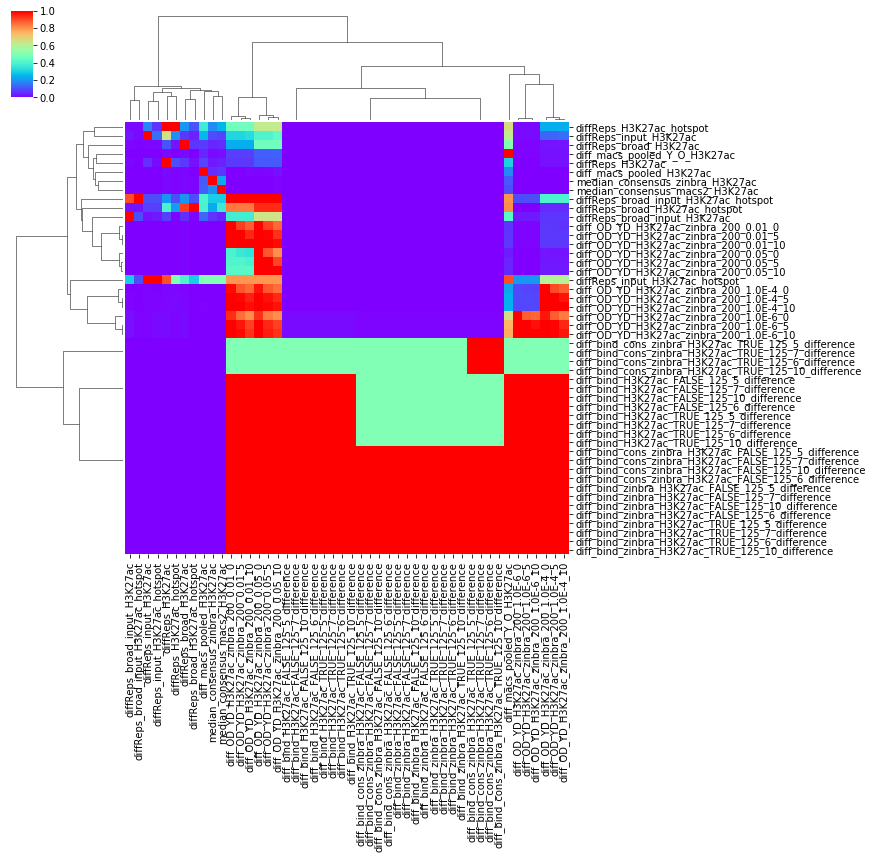

In [10]:
do_plot("m1")

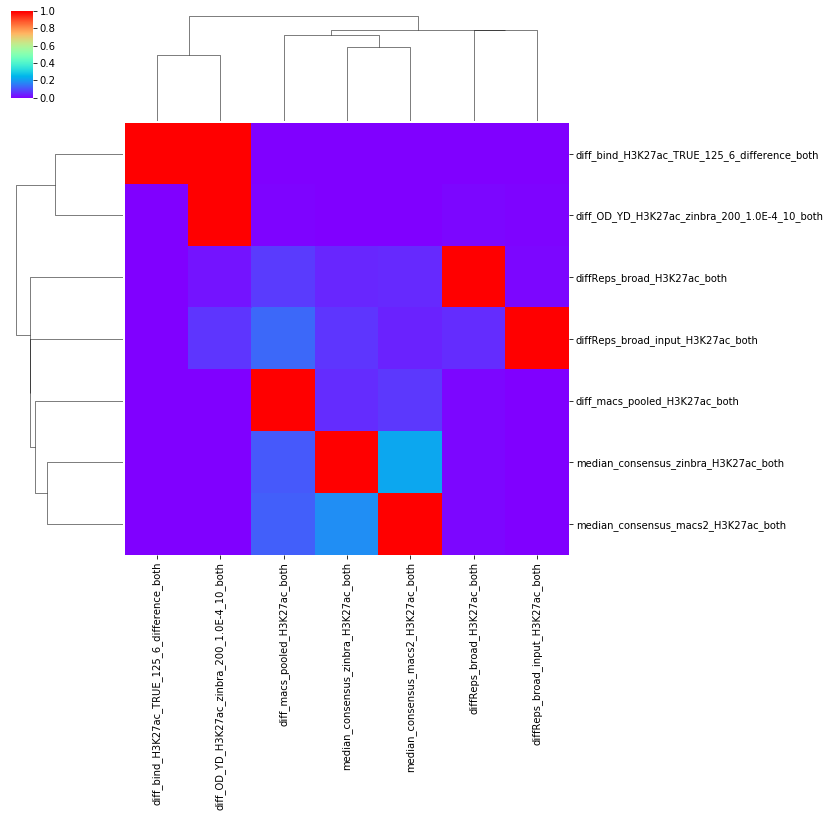

In [11]:
do_plot("m1", [
    "diff_bind_H3K27ac_TRUE_125_6_difference_both.bed",
    "diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_10_both.bed",
    "diff_macs_pooled_H3K27ac_both.bed",
    "median_consensus_zinbra_H3K27ac_both.bed",
    "median_consensus_macs2_H3K27ac_both.bed",
    "diffReps_broad_H3K27ac_both.bed",
    "diffReps_broad_input_H3K27ac_both.bed"])

In [12]:
print_best("jaccard")

,f1,f2,score
0,diff_macs_pooled_H3K27ac_both.bed,median_consensus_macs2_H3K27ac_both.bed,0.047922
1,diff_macs_pooled_H3K27ac_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.039773
2,diff_macs_pooled_Y_O_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.01_10_both.bed,0.039112
3,diffReps_broad_H3K27ac_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.014320
4,diff_bind_H3K27ac_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed,0.014286
5,diff_macs_pooled_Y_O_H3K27ac_both.bed,median_consensus_macs2_H3K27ac_both.bed,0.013965
6,diffReps_input_H3K27ac_hotspot_both.bed,diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed,0.013514
7,diffReps_H3K27ac_both.bed,diff_macs_pooled_H3K27ac_both.bed,0.012211
8,diffReps_broad_H3K27ac_both.bed,median_consensus_zinbra_H3K27ac_both.bed,0.008696
9,diff_macs_pooled_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.05_10_both.bed,0.001942


In [13]:
print_best("m1")

,f1,f2,score
0,diffReps_broad_input_H3K27ac_hotspot_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.05_0_both.bed,1.000000
1,diff_bind_H3K27ac_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.05_0_both.bed,1.000000
2,diff_bind_H3K27ac_TRUE_125_6_difference_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,1.000000
3,diffReps_input_H3K27ac_hotspot_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.900000
4,diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.764286
5,diffReps_input_H3K27ac_hotspot_both.bed,median_consensus_zinbra_H3K27ac_both.bed,0.500000
6,diffReps_input_H3K27ac_hotspot_both.bed,diff_macs_pooled_H3K27ac_both.bed,0.500000
7,diff_macs_pooled_H3K27ac_both.bed,diff_macs_pooled_Y_O_H3K27ac_both.bed,0.182190
8,diff_macs_pooled_Y_O_H3K27ac_both.bed,diff_OD_YD_H3K27ac_zinbra_200_0.05_10_both.bed,0.126043
9,median_consensus_macs2_H3K27ac_both.bed,diff_macs_pooled_H3K27ac_both.bed,0.122648


In [14]:
diffs.get_bed_files_produced()

['diff_bind_H3K27ac_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K27ac_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K27ac_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27ac_FALSE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27ac_TRUE_125_6_difference_both.bed',
 'diff_bind_cons_zi

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed >/tmp/tmp7b4enf07.tmp/counts.bed


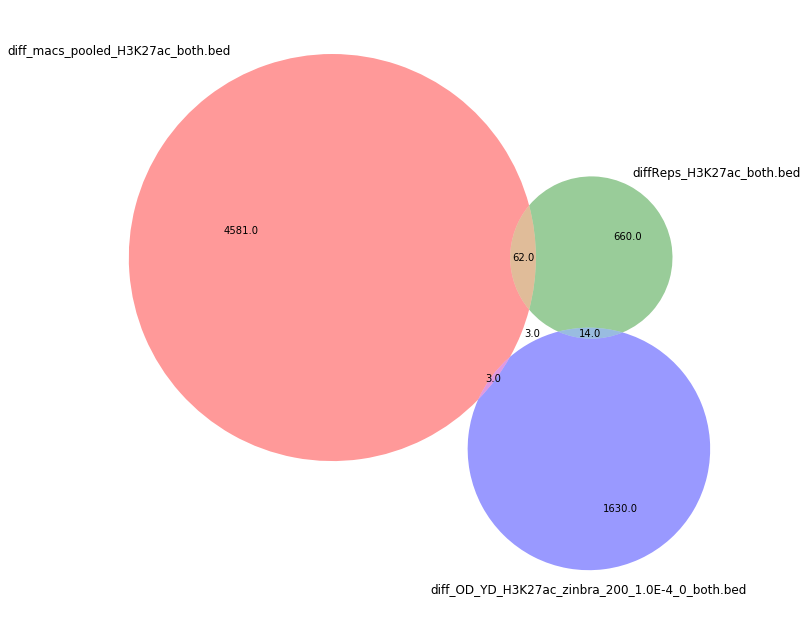

In [15]:
diffs.plot_venn3('diff_macs_pooled_H3K27ac_both.bed', 
                 'diffReps_H3K27ac_both.bed', 
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed >/tmp/tmppsgadip_.tmp/counts.bed


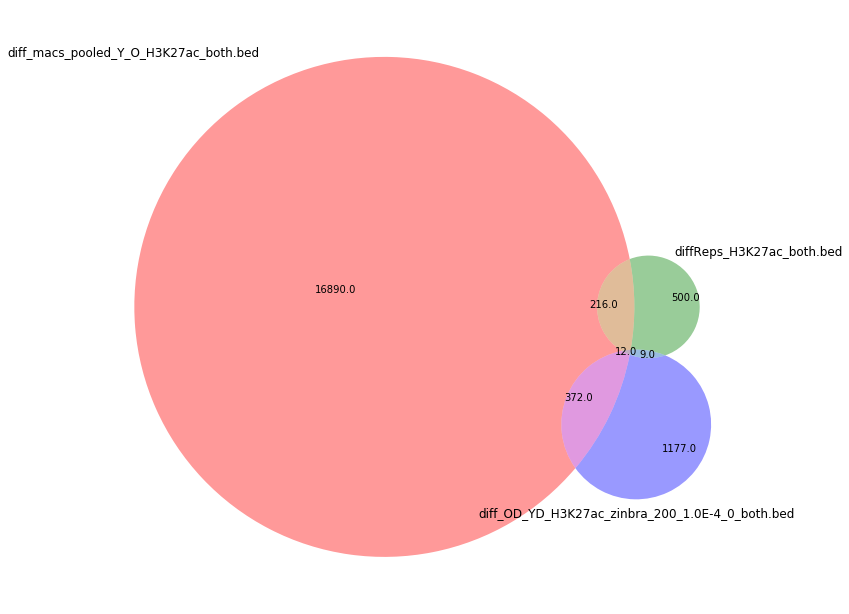

In [16]:
diffs.plot_venn3('diff_macs_pooled_Y_O_H3K27ac_both.bed', 
                 'diffReps_H3K27ac_both.bed', 
                 'diff_OD_YD_H3K27ac_zinbra_200_1.0E-4_0_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diffReps_broad_H3K27ac_hotspot_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed >/tmp/tmpee70a06y.tmp/counts.bed
0


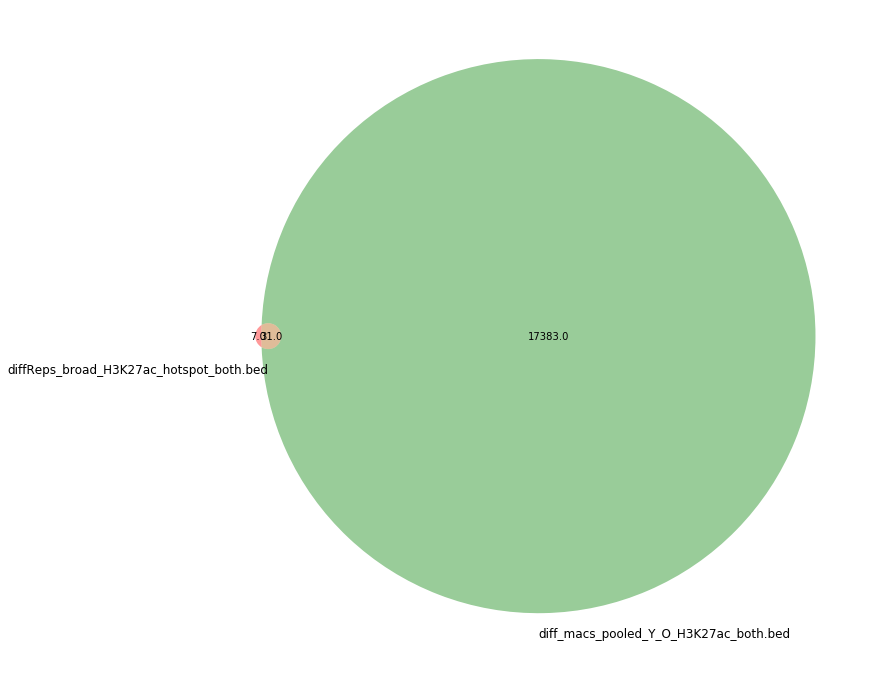

In [17]:
diffs.plot_venn2('diffReps_broad_H3K27ac_hotspot_both.bed', 'diff_macs_pooled_Y_O_H3K27ac_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27ac/both/diff_macs_pooled_Y_O_H3K27ac_both.bed >/tmp/tmpv3r6aew1.tmp/counts.bed
0


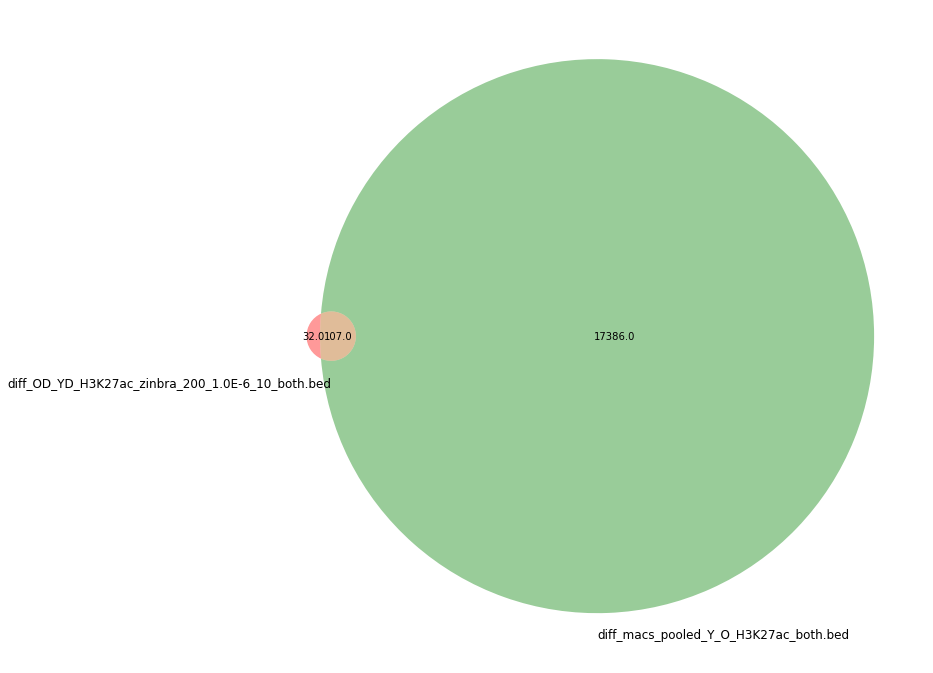

In [18]:
diffs.plot_venn2('diff_OD_YD_H3K27ac_zinbra_200_1.0E-6_10_both.bed', 
                 'diff_macs_pooled_Y_O_H3K27ac_both.bed')

# H3K27me3

In [19]:
diffs = diffs_dict['H3K27me3']

In [20]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K27me3_TRUE_125_6_difference,0,0,0
1,diff_bind_H3K27me3_TRUE_125_10_difference,0,0,0
2,diff_bind_H3K27me3_TRUE_125_7_difference,0,0,0
3,diff_bind_H3K27me3_TRUE_125_5_difference,0,0,0
4,diff_bind_H3K27me3_FALSE_125_6_difference,2,2,0
5,diff_bind_H3K27me3_FALSE_125_10_difference,2,2,0
6,diff_bind_H3K27me3_FALSE_125_7_difference,2,2,0
7,diff_bind_H3K27me3_FALSE_125_5_difference,3,3,0
8,diff_bind_zinbra_H3K27me3_TRUE_125_6_difference,5,1,4
9,diff_bind_zinbra_H3K27me3_TRUE_125_10_difference,5,1,4


/tmp/tmpmv9m4vrv.tmp


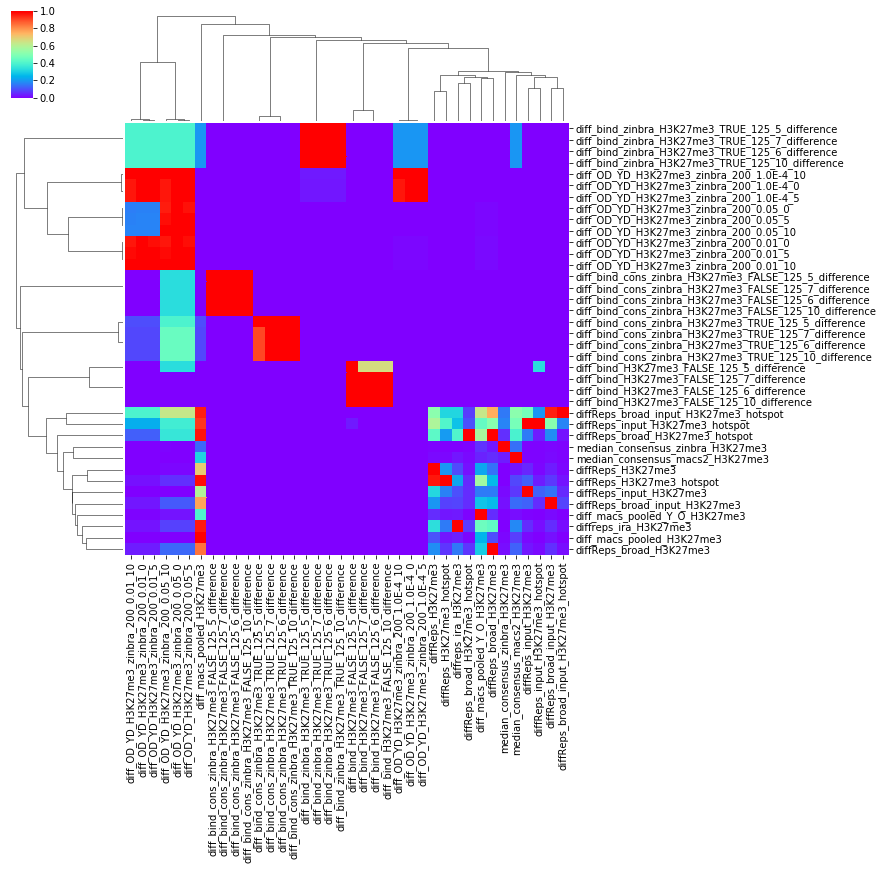

In [21]:
intersection = diffs.count_intersections()

do_plot("m1")

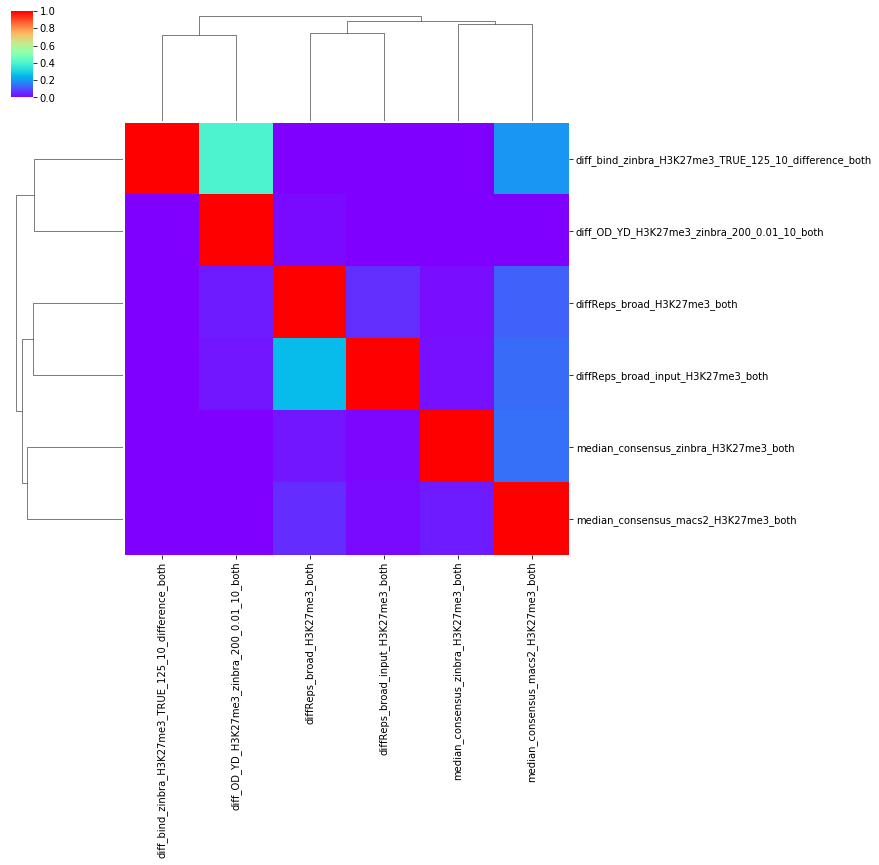

In [22]:
do_plot("m1", ['diff_bind_zinbra_H3K27me3_TRUE_125_10_difference_both.bed',
               'diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed',
               'median_consensus_zinbra_H3K27me3_both.bed',
               'median_consensus_macs2_H3K27me3_both.bed',
               'diffReps_broad_H3K27me3_both.bed',
               'diffReps_broad_input_H3K27me3_both.bed'])


In [23]:
print_best("jaccard")

,f1,f2,score
0,diff_macs_pooled_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.183596
1,diffReps_broad_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.132823
2,diffReps_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.102140
3,diff_macs_pooled_H3K27me3_both.bed,median_consensus_macs2_H3K27me3_both.bed,0.067949
4,diffReps_broad_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.050465
5,diff_macs_pooled_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.041957
6,diffReps_broad_H3K27me3_both.bed,median_consensus_macs2_H3K27me3_both.bed,0.041334
7,diffReps_input_H3K27me3_hotspot_both.bed,diff_bind_H3K27me3_FALSE_125_5_difference_both...,0.032258
8,diff_macs_pooled_Y_O_H3K27me3_both.bed,diffreps_ira_H3K27me3_both.bed,0.030961
9,diff_bind_zinbra_H3K27me3_TRUE_125_6_differenc...,diff_OD_YD_H3K27me3_zinbra_200_1.0E-4_10_both.bed,0.027778


In [24]:
print_best("m1")

,f1,f2,score
0,diffReps_H3K27me3_hotspot_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.980892
1,diffreps_ira_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.967816
2,diffReps_broad_input_H3K27me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.640000
3,diffReps_broad_input_H3K27me3_hotspot_both.bed,diff_OD_YD_H3K27me3_zinbra_200_0.05_0_both.bed,0.640000
4,diffReps_broad_input_H3K27me3_hotspot_both.bed,median_consensus_macs2_H3K27me3_both.bed,0.520000
5,diffreps_ira_H3K27me3_both.bed,diff_macs_pooled_Y_O_H3K27me3_both.bed,0.462069
6,diff_bind_cons_zinbra_H3K27me3_TRUE_125_6_diff...,diff_OD_YD_H3K27me3_zinbra_200_0.05_0_both.bed,0.454545
7,diffreps_ira_H3K27me3_both.bed,diffReps_broad_H3K27me3_both.bed,0.439080
8,diffReps_broad_H3K27me3_hotspot_both.bed,diffreps_ira_H3K27me3_both.bed,0.407407
9,diff_macs_pooled_Y_O_H3K27me3_both.bed,diff_macs_pooled_H3K27me3_both.bed,0.403484


In [25]:
diffs.get_bed_files_produced()

['diff_bind_H3K27me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K27me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K27me3_TRUE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_TRUE_125_6_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_TRUE_125_10_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_TRUE_125_7_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_TRUE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_FALSE_125_6_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_FALSE_125_10_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_FALSE_125_7_difference_both.bed',
 'diff_bind_cons_zinbra_H3K27me3_FALSE_125_5_difference_both.bed',


bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmpkqlv3pie.tmp/counts.bed


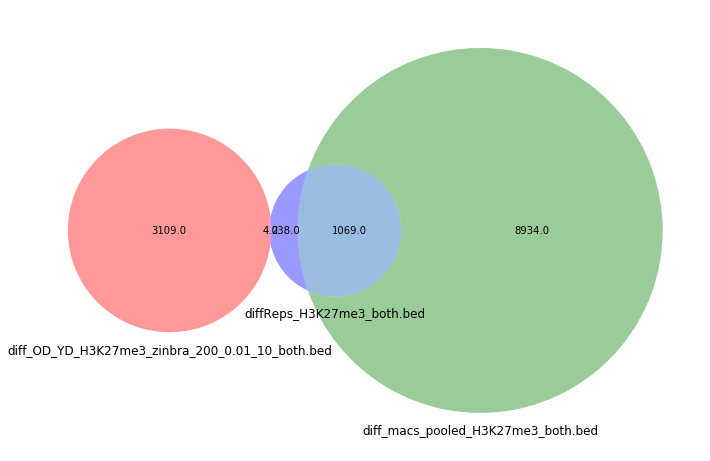

In [26]:
diffs.plot_venn3('diff_OD_YD_H3K27me3_zinbra_200_0.01_10_both.bed', 
                 'diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmpmxu5o4u_.tmp/counts.bed


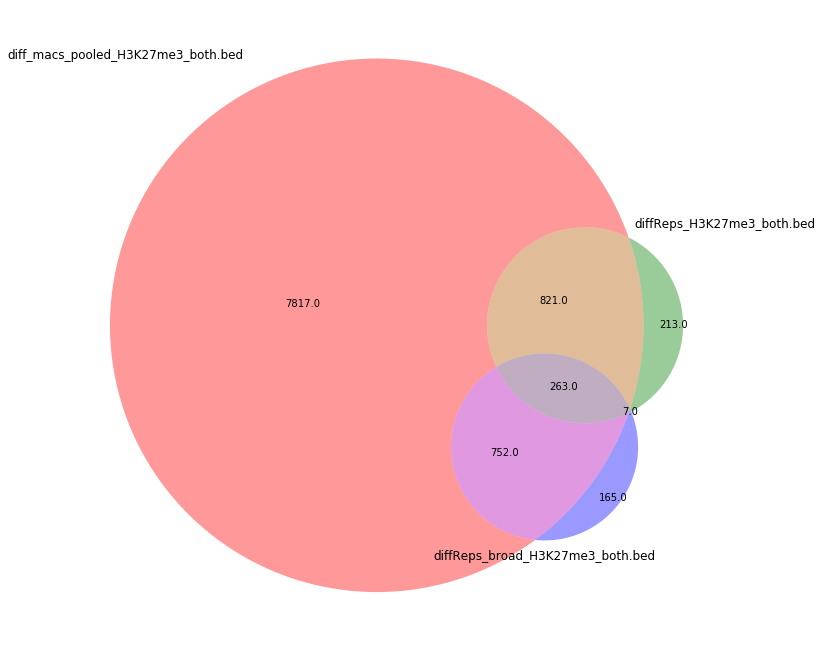

In [27]:
diffs.plot_venn3('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_H3K27me3_both.bed >/tmp/tmpfa1l7a8t.tmp/counts.bed
0


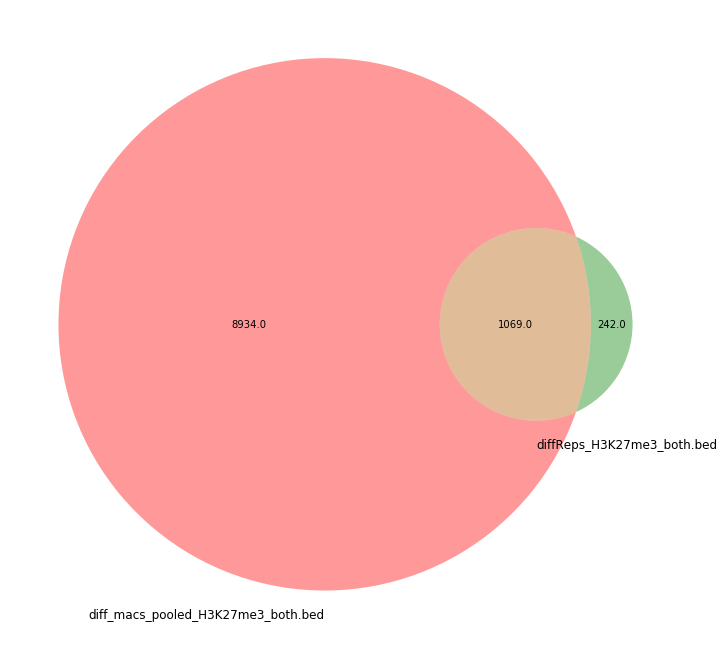

In [28]:
diffs.plot_venn2('diff_macs_pooled_H3K27me3_both.bed',
                 'diffReps_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_OD_YD_H3K27me3_zinbra_200_0.05_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diff_macs_pooled_Y_O_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmp1bcnnvm1.tmp/counts.bed


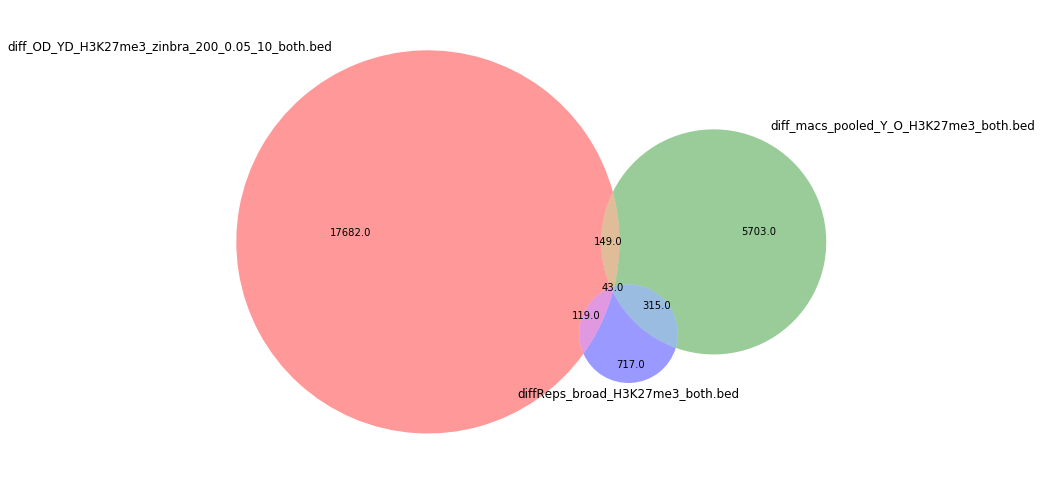

In [29]:
diffs.plot_venn3('diff_OD_YD_H3K27me3_zinbra_200_0.05_10_both.bed', 
                 'diff_macs_pooled_Y_O_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffreps_ira_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_input_H3K27me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed >/tmp/tmptt5ddz7l.tmp/counts.bed


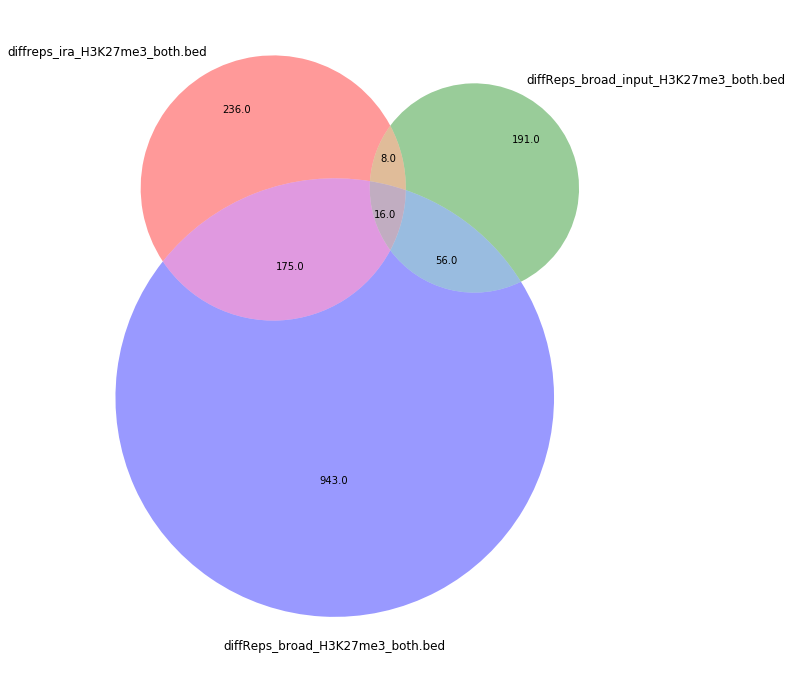

In [30]:
diffs.plot_venn3('diffreps_ira_H3K27me3_both.bed', 
                 'diffReps_broad_input_H3K27me3_both.bed',
                 'diffReps_broad_H3K27me3_both.bed')

## H3K4me1

In [31]:
diffs = diffs_dict['H3K4me1']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K4me1_TRUE_125_6_difference,2,0,2
1,diff_bind_H3K4me1_TRUE_125_10_difference,2,0,2
2,diff_bind_H3K4me1_TRUE_125_7_difference,2,0,2
3,diff_bind_H3K4me1_TRUE_125_5_difference,2,0,2
4,diff_bind_H3K4me1_FALSE_125_6_difference,0,0,0
5,diff_bind_H3K4me1_FALSE_125_10_difference,0,0,0
6,diff_bind_H3K4me1_FALSE_125_7_difference,0,0,0
7,diff_bind_H3K4me1_FALSE_125_5_difference,0,0,0
8,diff_bind_zinbra_H3K4me1_TRUE_125_6_difference,2,0,2
9,diff_bind_zinbra_H3K4me1_TRUE_125_10_difference,2,0,2


/tmp/tmpyc46_i7u.tmp


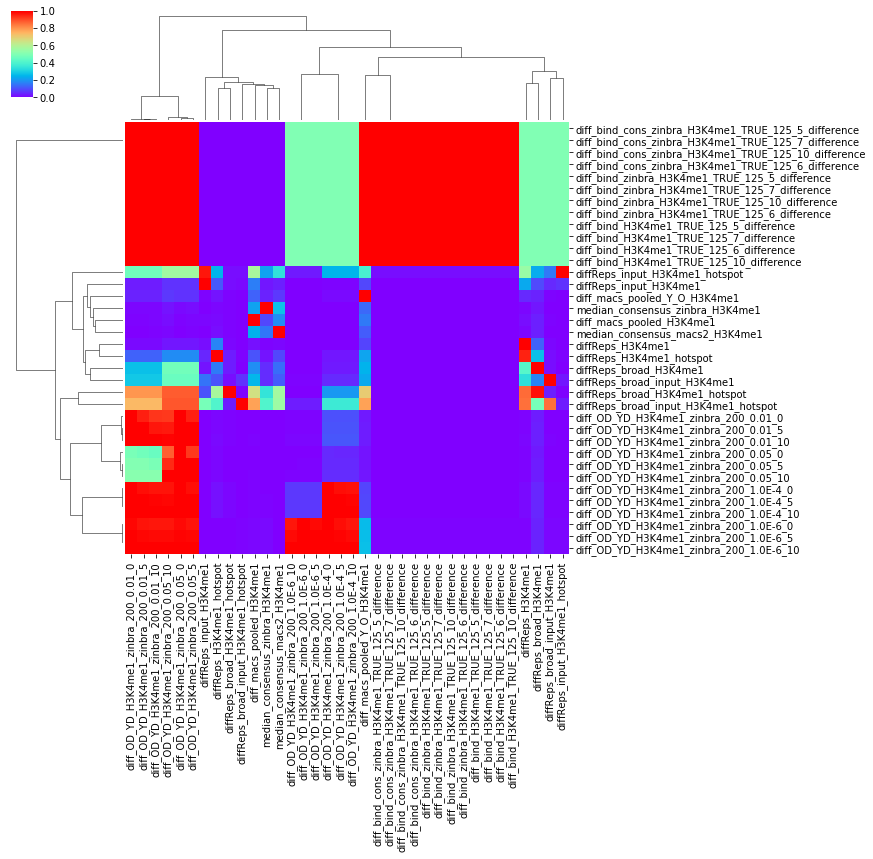

In [32]:
intersection = diffs.count_intersections()

do_plot("m1")

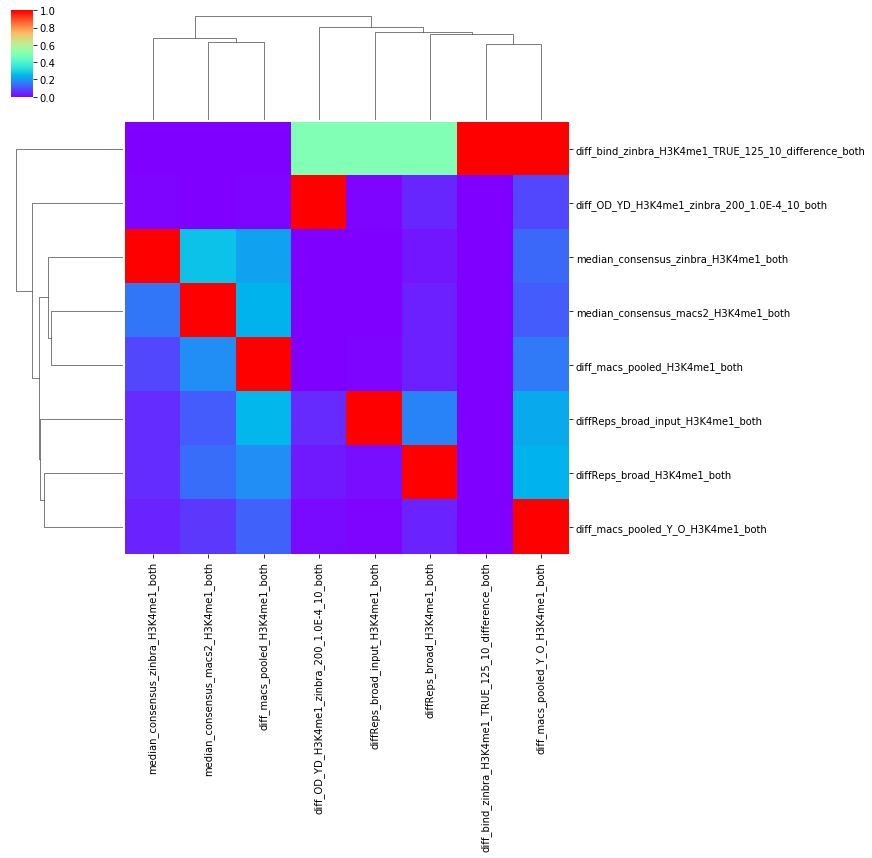

In [33]:
do_plot("m1", ['diff_bind_zinbra_H3K4me1_TRUE_125_10_difference_both.bed',
               'diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_10_both.bed',
               'median_consensus_zinbra_H3K4me1_both.bed',
               'median_consensus_macs2_H3K4me1_both.bed',
               'diffReps_broad_H3K4me1_both.bed',
               'diffReps_broad_input_H3K4me1_both.bed',
               'diff_macs_pooled_H3K4me1_both.bed',
               'diff_macs_pooled_Y_O_H3K4me1_both.bed'])

In [34]:
print_best("jaccard")

,f1,f2,score
0,diff_macs_pooled_H3K4me1_both.bed,median_consensus_macs2_H3K4me1_both.bed,0.119403
1,diff_macs_pooled_H3K4me1_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.076224
2,diff_macs_pooled_Y_O_H3K4me1_both.bed,median_consensus_macs2_H3K4me1_both.bed,0.047298
3,diffReps_broad_H3K4me1_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.040653
4,diffReps_broad_H3K4me1_both.bed,diff_OD_YD_H3K4me1_zinbra_200_0.01_10_both.bed,0.037605
5,diffReps_broad_H3K4me1_both.bed,diff_macs_pooled_H3K4me1_both.bed,0.036234
6,diffReps_broad_H3K4me1_both.bed,median_consensus_macs2_H3K4me1_both.bed,0.033772
7,diff_macs_pooled_Y_O_H3K4me1_both.bed,diff_OD_YD_H3K4me1_zinbra_200_0.05_10_both.bed,0.021790
8,diffReps_input_H3K4me1_hotspot_both.bed,diff_bind_H3K4me1_TRUE_125_6_difference_both.bed,0.015385
9,diff_bind_H3K4me1_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_10_both.bed,0.005000


In [35]:
print_best("m1")

,f1,f2,score
0,diff_bind_H3K4me1_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed,1.000000
1,diff_bind_H3K4me1_TRUE_125_6_difference_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,1.000000
2,diffReps_broad_input_H3K4me1_hotspot_both.bed,diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed,0.888889
3,diffReps_broad_input_H3K4me1_hotspot_both.bed,diff_macs_pooled_H3K4me1_both.bed,0.777778
4,diffReps_broad_input_H3K4me1_hotspot_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.777778
5,diffReps_broad_H3K4me1_hotspot_both.bed,median_consensus_macs2_H3K4me1_both.bed,0.566667
6,diff_bind_H3K4me1_TRUE_125_6_difference_both.bed,diffReps_H3K4me1_both.bed,0.500000
7,diff_OD_YD_H3K4me1_zinbra_200_1.0E-6_10_both.bed,diff_macs_pooled_Y_O_H3K4me1_both.bed,0.271357
8,median_consensus_macs2_H3K4me1_both.bed,diff_macs_pooled_H3K4me1_both.bed,0.247339
9,diff_macs_pooled_H3K4me1_both.bed,median_consensus_macs2_H3K4me1_both.bed,0.187548


In [36]:
diffs.get_bed_files_produced()

['diff_bind_H3K4me1_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K4me1_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me1_TRUE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me1_TRUE_125_6_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me1_TRUE_125_10_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me1_TRUE_125_7_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me1_TRUE_125_5_difference_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.05_10_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_zinbra_200_0.

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_macs_pooled_Y_O_H3K4me1_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diffReps_H3K4me1_both.bed >/tmp/tmp6i0pnevo.tmp/counts.bed


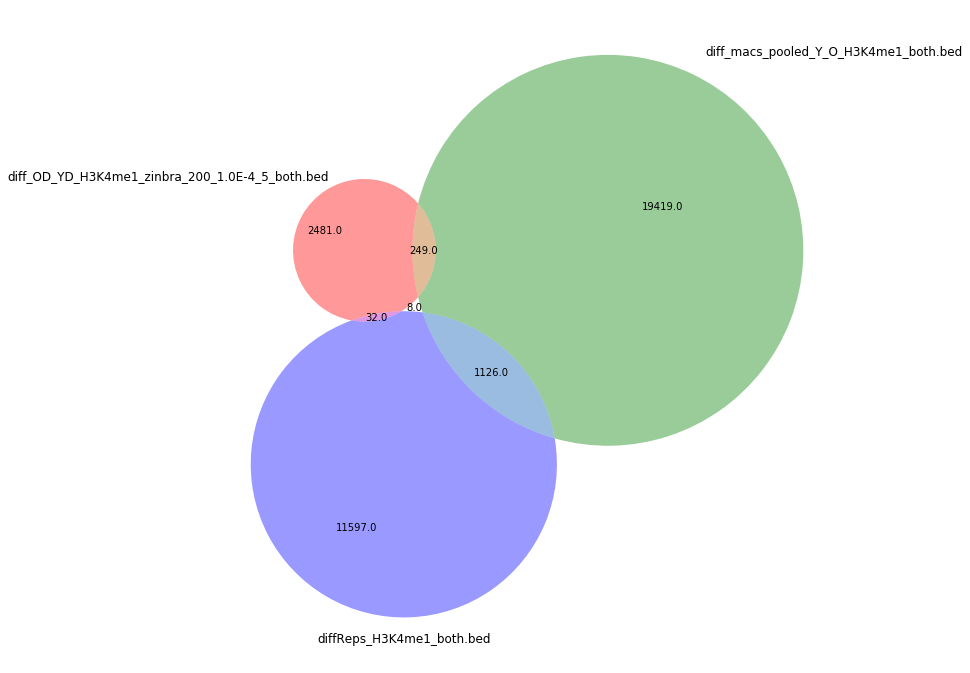

In [37]:
diffs.plot_venn3('diff_OD_YD_H3K4me1_zinbra_200_1.0E-4_5_both.bed', 
                 'diff_macs_pooled_Y_O_H3K4me1_both.bed',
                 'diffReps_H3K4me1_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diffReps_broad_input_H3K4me1_hotspot_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed >/tmp/tmp2_023_4l.tmp/counts.bed
0


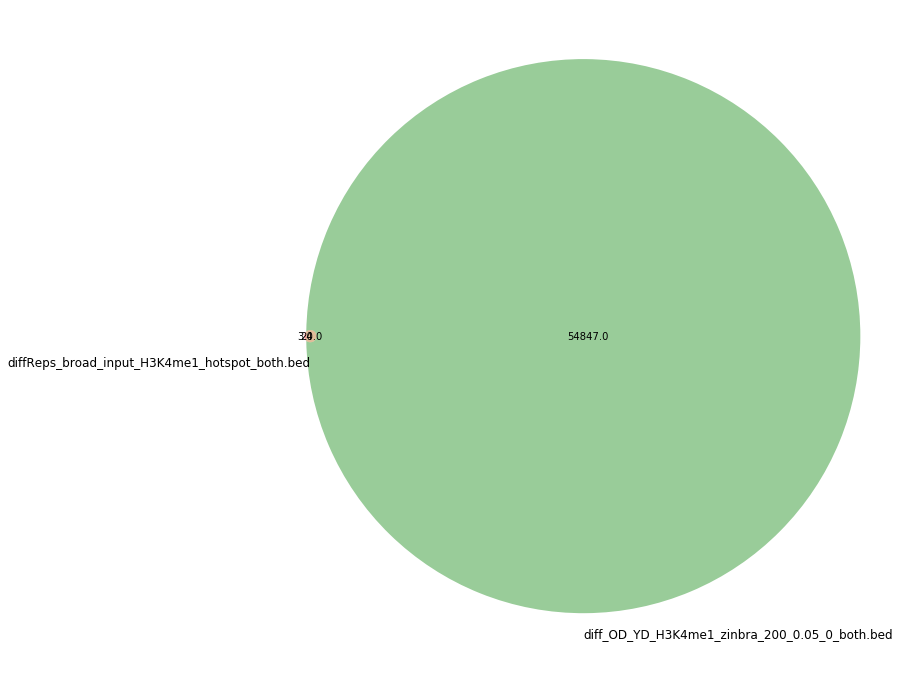

In [38]:
diffs.plot_venn2("diffReps_broad_input_H3K4me1_hotspot_both.bed",
                 "diff_OD_YD_H3K4me1_zinbra_200_0.05_0_both.bed")

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/median_consensus_macs2_H3K4me1_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me1/both/diff_macs_pooled_H3K4me1_both.bed >/tmp/tmpvzgqnhwi.tmp/counts.bed
0


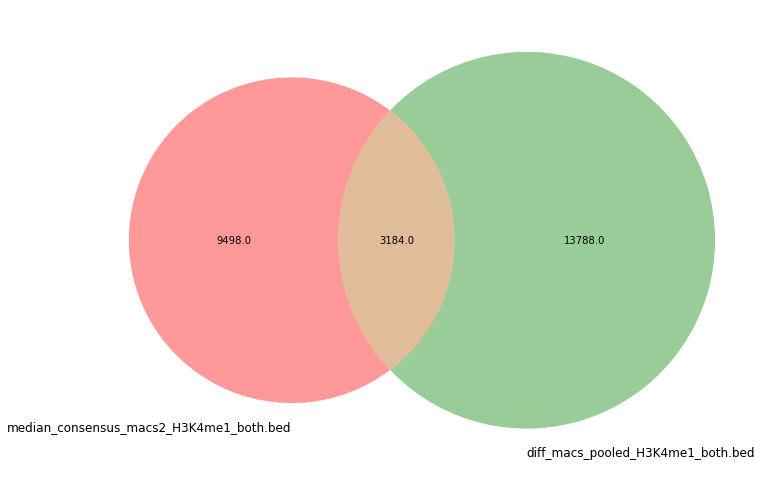

In [39]:
diffs.plot_venn2("median_consensus_macs2_H3K4me1_both.bed", 
                 "diff_macs_pooled_H3K4me1_both.bed")

## H3K4me3

In [40]:
diffs = diffs_dict['H3K4me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K4me3_TRUE_125_6_difference,30,29,1
1,diff_bind_H3K4me3_TRUE_125_10_difference,30,29,1
2,diff_bind_H3K4me3_TRUE_125_7_difference,30,29,1
3,diff_bind_H3K4me3_TRUE_125_5_difference,32,31,1
4,diff_bind_H3K4me3_FALSE_125_6_difference,489,488,1
5,diff_bind_H3K4me3_FALSE_125_10_difference,489,488,1
6,diff_bind_H3K4me3_FALSE_125_7_difference,489,488,1
7,diff_bind_H3K4me3_FALSE_125_5_difference,489,488,1
8,diff_bind_zinbra_H3K4me3_TRUE_125_6_difference,1448,1446,2
9,diff_bind_zinbra_H3K4me3_TRUE_125_10_difference,1448,1446,2


/tmp/tmp__qd409d.tmp


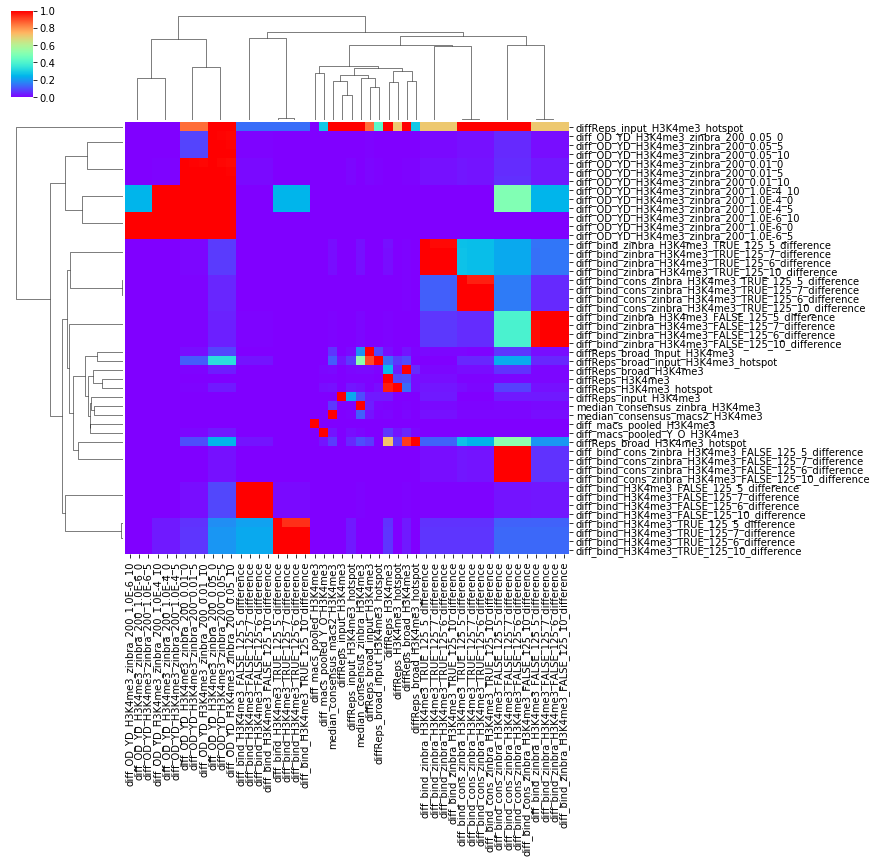

In [41]:
intersection = diffs.count_intersections()

do_plot("m1")

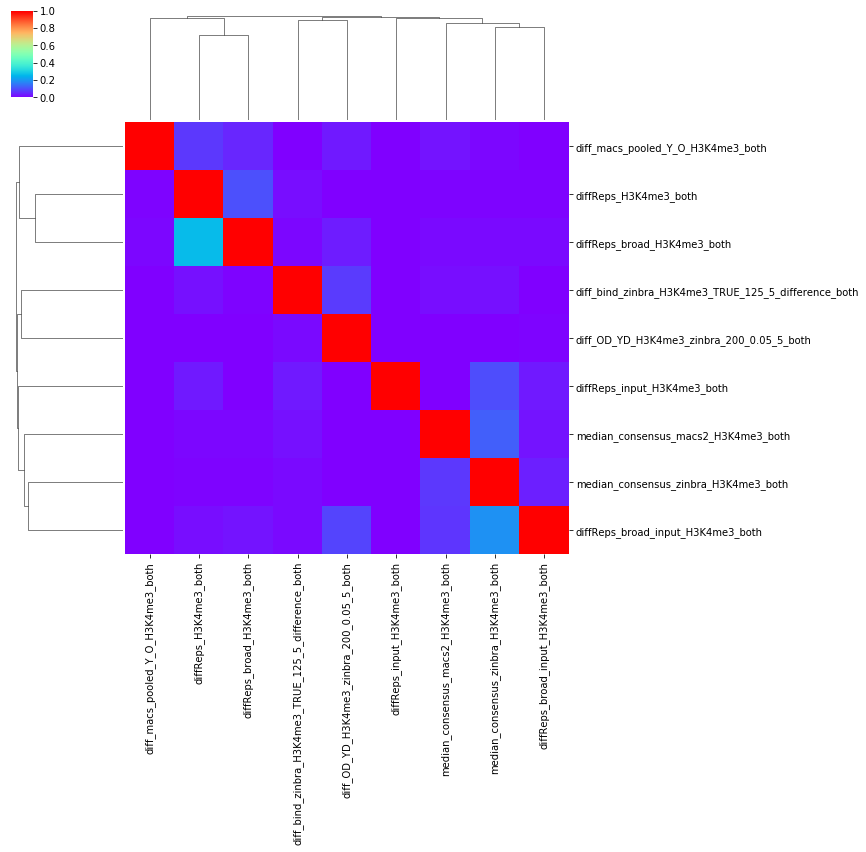

In [42]:
do_plot("m1", ['diff_bind_zinbra_H3K4me3_TRUE_125_5_difference_both.bed',
               'diff_OD_YD_H3K4me3_zinbra_200_0.05_5_both.bed',
               'diff_macs_pooled_Y_O_H3K4me3_both.bed',
               'median_consensus_zinbra_H3K4me3_both.bed',
               'median_consensus_macs2_H3K4me3_both.bed',
               'diffReps_H3K4me3_both.bed',
               'diffReps_broad_H3K4me3_both.bed',
               'diffReps_broad_input_H3K4me3_both.bed',
               'diffReps_input_H3K4me3_both.bed'])

In [43]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_input_H3K4me3_both.bed,median_consensus_zinbra_H3K4me3_both.bed,0.034542
1,diff_bind_H3K4me3_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_0_both.bed,0.030303
2,diffReps_input_H3K4me3_hotspot_both.bed,diff_bind_H3K4me3_TRUE_125_6_difference_both.bed,0.027778
3,diffReps_input_H3K4me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K4me3_both.bed,0.015385
4,diff_bind_zinbra_H3K4me3_TRUE_125_5_difference...,median_consensus_macs2_H3K4me3_both.bed,0.009946
5,diffReps_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed,0.009023
6,diff_macs_pooled_Y_O_H3K4me3_both.bed,median_consensus_macs2_H3K4me3_both.bed,0.002308
7,diff_macs_pooled_Y_O_H3K4me3_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed,0.001269
8,median_consensus_zinbra_H3K4me3_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.05_10_both.bed,0.000426
9,diffReps_H3K4me3_both.bed,diff_macs_pooled_H3K4me3_both.bed,0.000000


In [44]:
print_best("m1")

,f1,f2,score
0,diffReps_input_H3K4me3_hotspot_both.bed,median_consensus_zinbra_H3K4me3_both.bed,1.000000
1,diffReps_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.05_0_both.bed,1.000000
2,diffReps_input_H3K4me3_hotspot_both.bed,diff_bind_cons_zinbra_H3K4me3_TRUE_125_6_diffe...,1.000000
3,diff_OD_YD_H3K4me3_zinbra_200_1.0E-4_0_both.bed,diff_bind_cons_zinbra_H3K4me3_FALSE_125_6_diff...,0.500000
4,diffReps_input_H3K4me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K4me3_both.bed,0.285714
5,diff_bind_H3K4me3_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.05_0_both.bed,0.200000
6,diff_macs_pooled_Y_O_H3K4me3_both.bed,diffReps_H3K4me3_both.bed,0.072000
7,diff_bind_H3K4me3_TRUE_125_6_difference_both.bed,diffReps_H3K4me3_both.bed,0.066667
8,median_consensus_zinbra_H3K4me3_both.bed,diffReps_broad_input_H3K4me3_both.bed,0.040359
9,diff_macs_pooled_Y_O_H3K4me3_both.bed,diff_OD_YD_H3K4me3_zinbra_200_0.05_0_both.bed,0.032000


In [45]:
diffs.get_bed_files_produced()

['diff_bind_H3K4me3_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K4me3_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K4me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K4me3_FALSE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K4me3_TRUE_125_6_difference_both.bed',
 'diff_bind_cons_zi

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diffReps_H3K4me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_macs_pooled_Y_O_H3K4me3_both.bed >/tmp/tmp9kn5ywjj.tmp/counts.bed


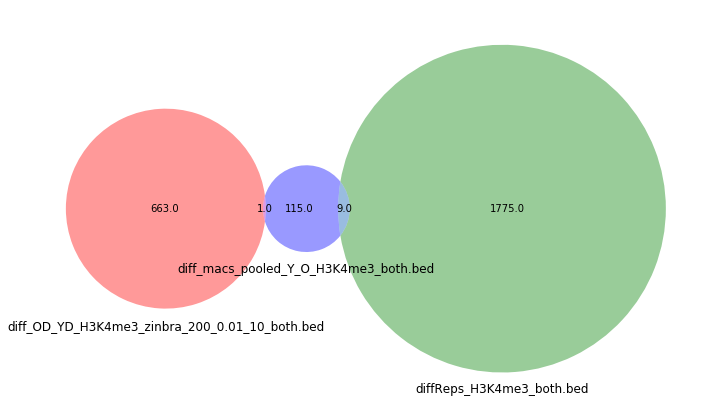

In [46]:
diffs.plot_venn3('diff_OD_YD_H3K4me3_zinbra_200_0.01_10_both.bed', 
                 'diffReps_H3K4me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K4me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_OD_YD_H3K4me3_zinbra_200_0.05_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diffReps_broad_H3K4me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K4me3/both/diff_macs_pooled_Y_O_H3K4me3_both.bed >/tmp/tmpdnuqed1p.tmp/counts.bed


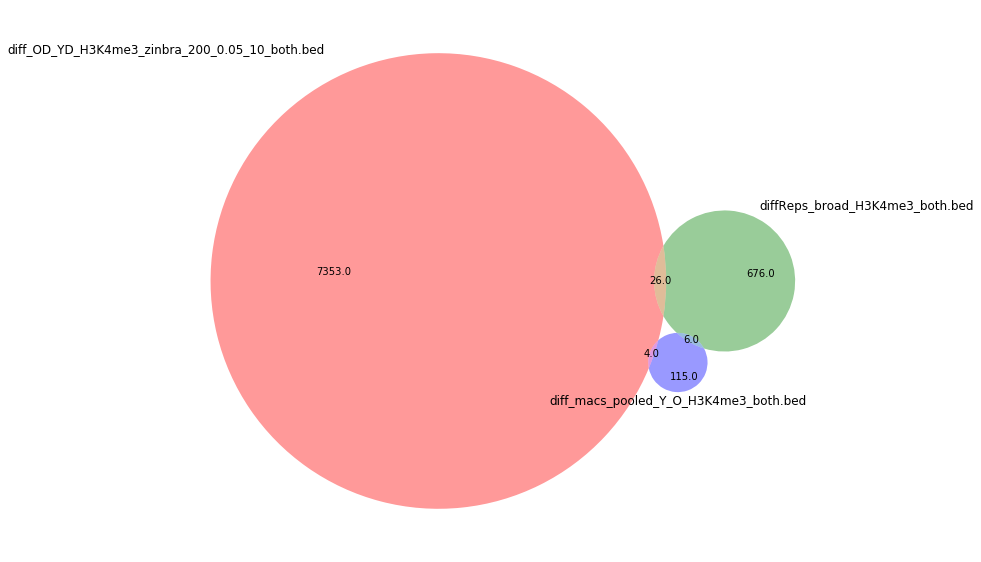

In [47]:
diffs.plot_venn3('diff_OD_YD_H3K4me3_zinbra_200_0.05_10_both.bed', 
                 'diffReps_broad_H3K4me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K4me3_both.bed')

## H3K36me3

In [48]:
diffs = diffs_dict['H3K36me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_H3K36me3_TRUE_125_6_difference,7,0,7
1,diff_bind_H3K36me3_TRUE_125_10_difference,7,0,7
2,diff_bind_H3K36me3_TRUE_125_7_difference,7,0,7
3,diff_bind_H3K36me3_TRUE_125_5_difference,7,0,7
4,diff_bind_H3K36me3_FALSE_125_6_difference,2,0,2
5,diff_bind_H3K36me3_FALSE_125_10_difference,2,0,2
6,diff_bind_H3K36me3_FALSE_125_7_difference,2,0,2
7,diff_bind_H3K36me3_FALSE_125_5_difference,2,0,2
8,diff_bind_zinbra_H3K36me3_TRUE_125_6_difference,2,0,2
9,diff_bind_zinbra_H3K36me3_TRUE_125_10_difference,2,0,2


/tmp/tmpaxo4am58.tmp


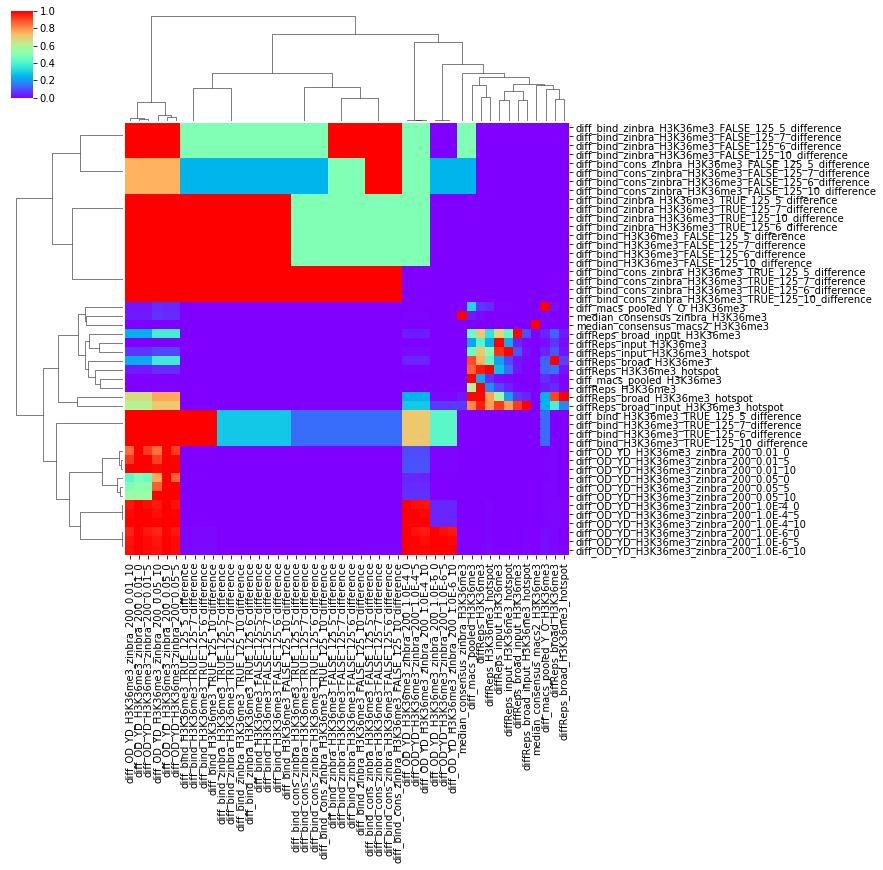

In [49]:
intersection = diffs.count_intersections()

do_plot("m1")

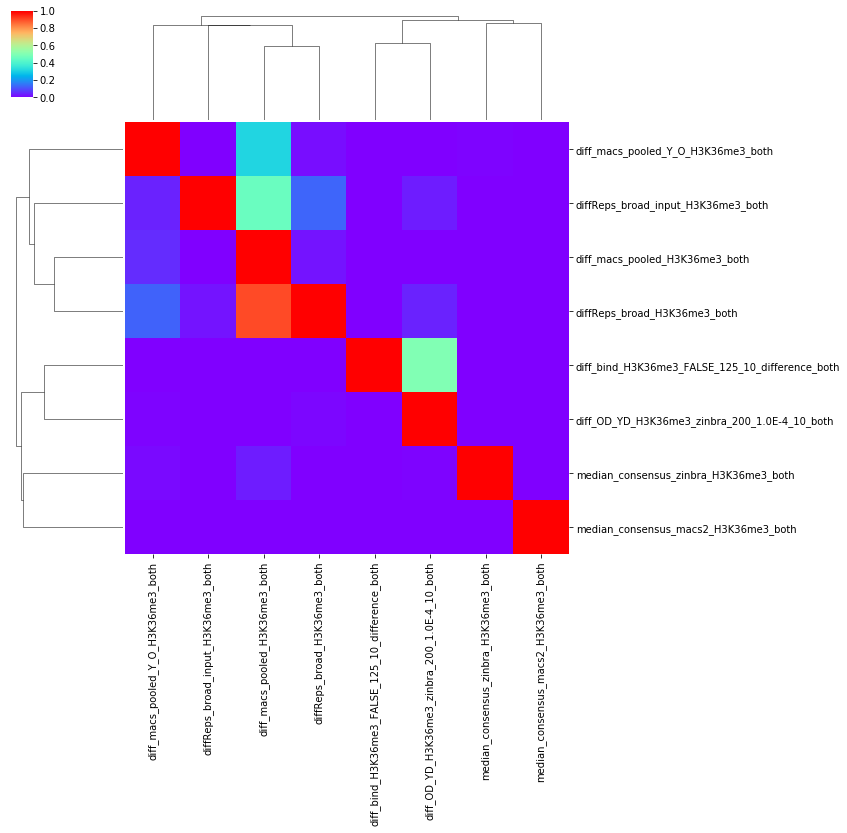

In [50]:
do_plot("m1", ['diff_bind_H3K36me3_FALSE_125_10_difference_both.bed',
               'diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
               'diff_macs_pooled_H3K36me3_both.bed',
               'diff_macs_pooled_Y_O_H3K36me3_both.bed',
               'median_consensus_zinbra_H3K36me3_both.bed',
               'median_consensus_macs2_H3K36me3_both.bed',
               'diffReps_broad_H3K36me3_both.bed',
               'diffReps_broad_input_H3K36me3_both.bed'])


In [51]:
print_best("jaccard")

,f1,f2,score
0,diffReps_H3K36me3_both.bed,diff_macs_pooled_H3K36me3_both.bed,0.203766
1,diff_macs_pooled_H3K36me3_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.049718
2,diffReps_H3K36me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.040312
3,diff_bind_H3K36me3_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K36me3_zinbra_200_1.0E-6_10_both.bed,0.011583
4,diffReps_broad_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed,0.008559
5,diff_macs_pooled_Y_O_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_200_0.05_10_both.bed,0.005167
6,diff_macs_pooled_Y_O_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.003332
7,median_consensus_zinbra_H3K36me3_both.bed,diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed,0.002020
8,diff_macs_pooled_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.001783
9,diffReps_H3K36me3_both.bed,median_consensus_zinbra_H3K36me3_both.bed,0.001485


In [52]:
print_best("m1")

,f1,f2,score
0,diff_bind_H3K36me3_TRUE_125_6_difference_both.bed,diff_OD_YD_H3K36me3_zinbra_200_0.05_0_both.bed,1.000000
1,diffReps_broad_H3K36me3_hotspot_both.bed,diff_macs_pooled_H3K36me3_both.bed,0.990826
2,diffReps_broad_H3K36me3_hotspot_both.bed,diff_OD_YD_H3K36me3_zinbra_200_0.05_0_both.bed,0.770642
3,diff_bind_zinbra_H3K36me3_FALSE_125_6_differen...,median_consensus_zinbra_H3K36me3_both.bed,0.500000
4,diff_bind_zinbra_H3K36me3_FALSE_125_6_differen...,diff_macs_pooled_H3K36me3_both.bed,0.500000
5,diff_macs_pooled_Y_O_H3K36me3_both.bed,diff_macs_pooled_H3K36me3_both.bed,0.315125
6,diffReps_broad_input_H3K36me3_hotspot_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.250000
7,diff_macs_pooled_H3K36me3_both.bed,diffReps_H3K36me3_both.bed,0.234454
8,diff_bind_H3K36me3_TRUE_125_6_difference_both.bed,diff_macs_pooled_Y_O_H3K36me3_both.bed,0.142857
9,diff_macs_pooled_Y_O_H3K36me3_both.bed,diffReps_H3K36me3_both.bed,0.073440


In [53]:
diffs.get_bed_files_produced()

['diff_bind_H3K36me3_TRUE_125_6_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_10_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_7_difference_both.bed',
 'diff_bind_H3K36me3_TRUE_125_5_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_6_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_10_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_7_difference_both.bed',
 'diff_bind_H3K36me3_FALSE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_TRUE_125_5_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_6_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_10_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_7_difference_both.bed',
 'diff_bind_zinbra_H3K36me3_FALSE_125_5_difference_both.bed',
 'diff_bind_cons_zinbra_H3K36me3_TRUE_125_6_difference_both.bed',
 '

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diffReps_H3K36me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmpvhl7qpfx.tmp/counts.bed


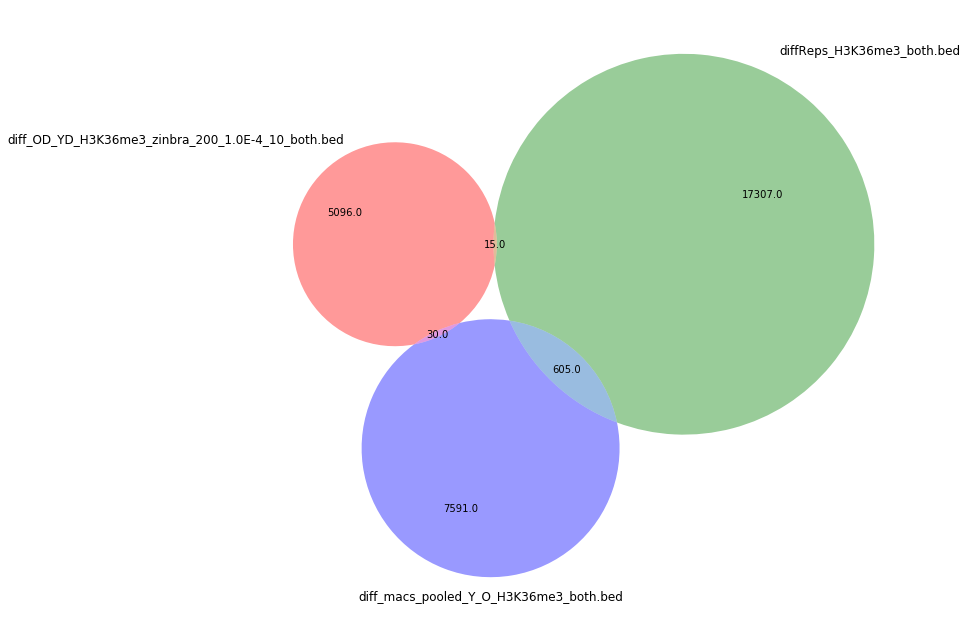

In [54]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed', 
                 'diffReps_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diffReps_broad_H3K36me3_both.bed /mnt/stripe/bio/experiments/compare-chip-seq-tools/processed/H3K36me3/both/diff_macs_pooled_Y_O_H3K36me3_both.bed >/tmp/tmp9vzp64ox.tmp/counts.bed


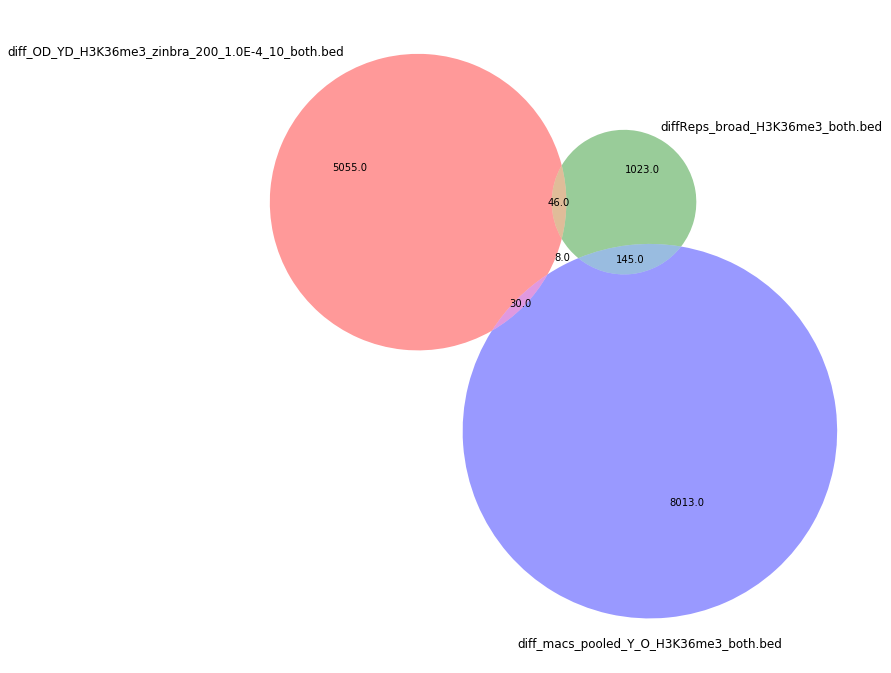

In [55]:
diffs.plot_venn3('diff_OD_YD_H3K36me3_zinbra_200_1.0E-4_10_both.bed',
                 'diffReps_broad_H3K36me3_both.bed',
                 'diff_macs_pooled_Y_O_H3K36me3_both.bed')